In [1]:
import Diagrams.Backend.Cairo.CmdLine

A relatively well-known puzzle is to find a sequence of moves by which
a knight can visit every square of a chessboard exactly once, without
repeating any squares.  This example computes such a tour and
visualizes the solution.



In [12]:
{-# LANGUAGE NoMonomorphismRestriction FlexibleContexts TypeFamilies #-}

import           Data.List                      (minimumBy, tails, (\\))
import           Data.Ord                       (comparing)
import           Diagrams.Prelude

First, we compute a tour by a brute force depth-first search (it does
not take very long).  This code is adapted from the [code found
here](http://rosettacode.org/wiki/Knight%27s_tour#Haskell).



In [3]:
type Square = (Int, Int)

board :: [Square]
board = [ (x,y) | x <- [0..7], y <- [0..7] ]

knightMoves :: Square -> [Square]
knightMoves (x,y) = filter (`elem` board) jumps
  where jumps = [ (x+i,y+j) | i <- jv, j <- jv, abs i /= abs j ]
        jv    = [1,-1,2,-2]

knightTour :: Square -> [Square]
knightTour sq = knightTour' [sq]
  where
    knightTour' moves@(lastMove:_)
        | null candMoves = reverse moves
        | otherwise = knightTour' $ newSquare : moves
      where newSquare   = minimumBy (comparing (length . findMoves)) candMoves
            candMoves   = findMoves lastMove
            findMoves s = knightMoves s \\ moves


Now we can go about visualizing a tour.  First, let's draw a chessboard:



In [5]:
boardSq :: Colour Double -> Diagram B
boardSq c = square 1 # lw none # fc c

chessBoard :: Int -> Diagram B
chessBoard n
  = vcat . map hcat . map (map boardSq)
  . take n . map (take n) . tails
  $ cycle [antiquewhite, saddlebrown]

Line 6: Use map once
Found:
map hcat . map (map boardSq) . take n . map (take n) . tails
Why not:
map (hcat . map boardSq) . take n . map (take n) . tails

Now, we need a way to convert `Square` coordinates (a pair of numbers
in the range 0-7) into actual coordinates on the chessboard.  Since
the chessboard ends up with its local origin in the center of the
top-left square, all we need to do is negate the $y$-coordinate:



In [7]:
squareToPoint :: Square -> P2 Double
squareToPoint (x,y) = fromIntegral x ^& negate (fromIntegral y)

To draw a knight on a given square, we simply translate the given image appropriately:



In [8]:
knight :: Square -> Diagram B -> Diagram B
knight sq knightImg = knightImg # moveTo (squareToPoint sq)

Given a tour, we turn it into a path using `fromVertices`,
and decorate the vertices with dots.



In [13]:
drawTour :: [Square] -> Diagram B
drawTour tour = tourPoints <> strokeP tourPath
  where
    tourPath   = fromVertices . map squareToPoint $ tour
    tourPoints = atPoints (concat . pathVertices $ tourPath) (repeat dot)
    dot = circle 0.05 # fc black

Finally, we load a knight image, size it to fit a square, and then put all the
previous pieces together:



In [14]:
example = do
  res <- loadImageEmb "doc/static/white-knight.png"
  let knightImg = case res of
        Left _    -> mempty
        Right img -> image img # sized (mkWidth 1)
  return $ mconcat
    [ knight tourStart knightImg
    , knight tourEnd knightImg
    , drawTour tour
    , chessBoard 8
    ]
  where
    tourStart = (1,3)
    tour      = knightTour tourStart
    tourEnd   = last tour

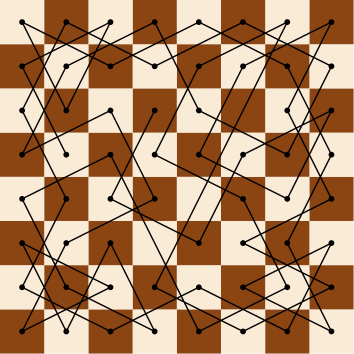

In [16]:
example